In [102]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_phase_portrait
import matplotlib.pyplot as plt

from MARBLE import utils, geometry, net, plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
def initial_conditions(n, reps):
    X0_range = [geometry.sample_2d(n, [[0,0],[1,1]], 'random', seed=0) for i in range(reps)]
    #Y0_range = [geometry.sample_2d(n, [[0,0],[1,1]], 'random', seed=i+reps) for i in range(reps)]
    #X0_range = [np.hstack([x,y]) for x,y in zip(X0_range,Y0_range)]
        
    return X0_range

def simulate_system(nu, X0, eps=1e-10):
    p, v = simulate_phase_portrait('cdc2_cyclin_reduced', t, X0, par = {'nu':nu,'a1':1,'a2':1,'b1':200,'b2':10,'K1':30,'K2':1,'gamma1':4,'gamma2':4})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = np.where((p_ < 1).all(1))[0]
        p_ = p_[ind,:]; v_ = v_[ind,:]
        ind = np.where((p_ > 0).any(1))[0]
        p_ = p_[ind,:]; v_ = v_[ind,:]
        pos.append(p_)
        v_ /= np.linalg.norm(v_,axis=1,keepdims=True)
        vel.append(v_)
        
    return pos, vel

def plot_phase_portrait(pos, vel, ax=None, node_feature=None, style='-'):
    if not isinstance(pos, list):
        pos = [pos]
    if not isinstance(vel, list):
        vel = [vel]

    for p, v in zip(pos, vel):
        ax = plotting.trajectories(p, v, ax=ax, style=style, node_feature=node_feature, lw=2, arrowhead=.1, axis=True, alpha=1.)
    ax.axis('square')
    
def reject_outliers(data, m=1):
    data = data.mean(1)
    return np.where(abs(data - np.median(data)) < m * np.std(data))[0]

def plot_embedding(emb, ax, slices, i, n_clusters=2):
    s = range(slices[i], slices[i+1])
    clusters = geometry.cluster(emb, cluster_typ='kmeans', n_clusters=n_clusters, seed=0)
    plotting.embedding(emb[s], clusters['labels'][s], ax=ax[0])
    plot_phase_portrait(pos_subsample[i], vel_subsample[i], ax[1], node_feature=clusters['labels'][s])

# For initial conditions, sample a rectangle uniformly

In [198]:
t0, t1, dt = 0, 5, 0.1
t = np.arange(t0, t1, dt)
n = 100

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [199]:
n_steps=20
nu = np.hstack([np.linspace(0,3,n_steps)])#,np.linspace(0.5,2,n_steps)])

pos, vel = [], []
X0_range = initial_conditions(n, len(nu))
for i, nu_ in enumerate(nu):
    p, v = simulate_system(nu_, X0_range[i])
            
    pos.append(p)
    vel.append(v)

# Display state spaces under four different parameter conditions

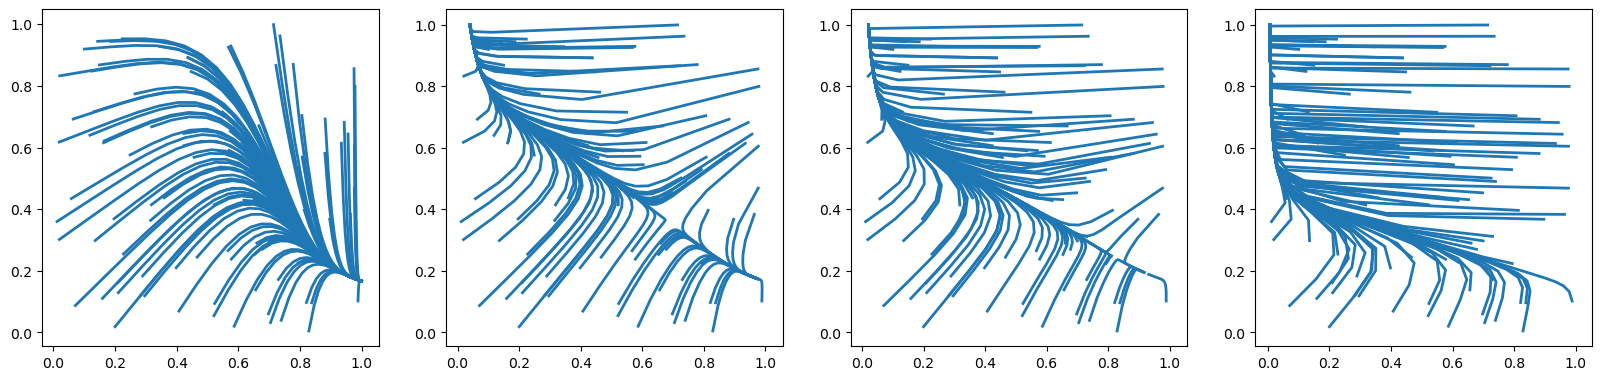

In [200]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
    
plot_phase_portrait(pos[0], vel[0], ax[0])
plot_phase_portrait(pos[n_steps//2-1], vel[n_steps//2-1], ax[1])
plot_phase_portrait(pos[n_steps//2+1], vel[n_steps//2+1], ax[2])
plot_phase_portrait(pos[-1], vel[-1], ax[3])

# Subsample phase portrait

In [201]:
pos = [np.vstack(p) for p in pos]
vel = [np.vstack(v) for v in vel]
pos_subsample, vel_subsample = [], []
for i, (p,v) in enumerate(zip(pos,vel)):
    ind, _ = geometry.furthest_point_sampling(p, stop_crit=0.02)
    pos_subsample.append(p[ind])
    vel_subsample.append(v[ind])

Compare phase portraits before and after subsampling

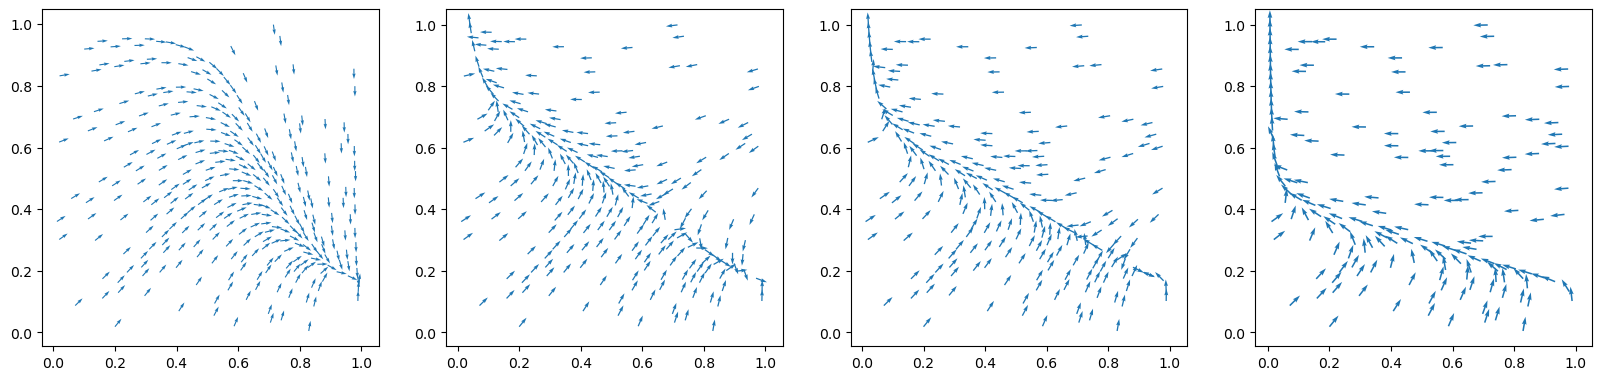

In [202]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
    
plot_phase_portrait(pos_subsample[0], vel_subsample[0], ax[0], style='>')
plot_phase_portrait(pos_subsample[n_steps//2-1], vel_subsample[n_steps//2-1], ax[1], style='>')
plot_phase_portrait(pos_subsample[n_steps//2+1], vel_subsample[n_steps//2+1], ax[2], style='>')
plot_phase_portrait(pos_subsample[-1], vel_subsample[-1], ax[3], style='>')

# Train network

In [203]:
k=15

data = utils.construct_dataset(pos_subsample, features=vel_subsample, graph_type='cknn', k=k)

In [204]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

par = {'batch_size': 256, #batch size
       'epochs': 40, #optimisation epochs
       'order': 3, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'diffusion': False,
       'inner_product_features': True,
       'pretrained':False,
       'second_training': True
      }

model = net(data, **par)
model.run_training(data)

---- Settings: 

batch_size : 256
epochs : 40
order : 3
n_lin_layers : 2
hidden_channels : 16
out_channels : 3
diffusion : False
inner_product_features : True
pretrained : False
second_training : True
lr : 0.01
vector : False
frac_geodesic_nb : 2.0
frac_sampled_nb : -1
var_explained : 0.9
diffusion_method : spectral
dropout : 0.0
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 2
dim_emb : 2
n_geodesic_nb : 30
n_sampled_nb : -1

---- Number of features to pass to the MLP:  15
---- Total number of parameters:  368
---- Treating features as scalar channels.

---- Training network ... 

Epoch: 1, Training loss: 22.0510, Validation loss: 21.6550
Epoch: 2, Training loss: 20.5684, Validation loss: 20.4084
Epoch: 3, Training loss: 19.9199, Validation loss: 19.6700
Epoch: 4, Training loss: 19.2773, Validation loss: 19.3729
Epoch: 5, Training loss: 18.4930, Validation loss: 18.5116
Epoch: 6, Training loss: 18.4248, Validation loss: 18.1690
Epoch: 7, Training lo

# Create embeddings

In [205]:
data = model.evaluate(data)

Performed MDS embedding on embedded results.


<AxesSubplot:>

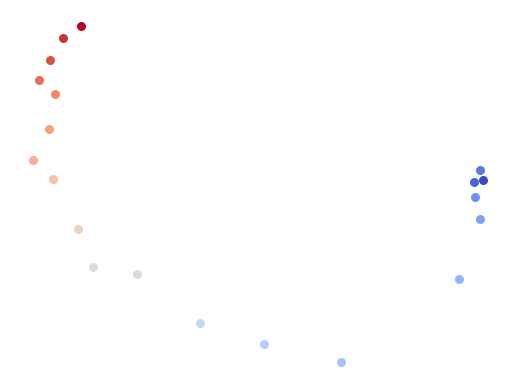

In [206]:
dist, gamma = geometry.compute_distribution_distances(data)
emb_MDS = geometry.embed(dist, embed_typ = 'MDS')
labels = nu#np.hstack([np.zeros(n_steps), np.ones(n_steps)])#nu
plotting.embedding(emb_MDS, labels, s=30, alpha=1)

# Distance matrix

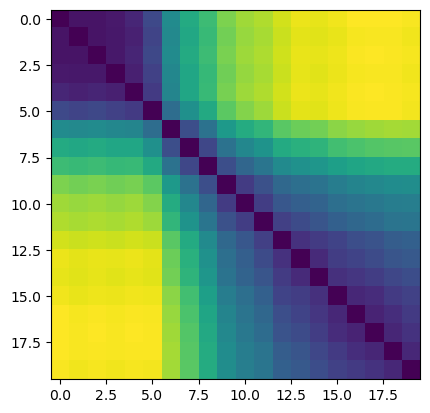

In [207]:
plt.imshow(dist)

# Cluster and visualise embedding

In [ ]:
emb = geometry.embed(data.emb)
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]
plotting.embedding(emb, data.y.numpy(), titles=titles)

In [ ]:
n_clusters=[2,4,6,8]
fig, ax = plt.subplots(len(n_clusters),4, figsize=(10,10))
slices=data._slice_dict['x']

snapshot=3
for i, n in enumerate(n_clusters):
    plot_embedding(emb, ax[:,:2][i], slices, snapshot, n_clusters=n)
    
snapshot=5
for i, n in enumerate(n_clusters):
    plot_embedding(emb, ax[:,2:][i], slices, snapshot, n_clusters=n)

In [ ]:
_, clusters, dist, gamma = geometry.cluster_embedding(data,cluster_typ='kmeans', embed_typ='umap', n_clusters=30)

In [ ]:
plt.imshow(g)